In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from scipy.interpolate import interp1d
from astroNN.nn.layers import MCDropout

2022-05-17 18:42:03.178471: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-17 18:42:03.178501: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-05-17 18:42:06.126901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 18:42:06.127597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-17 18:42:06.127720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-17 18:42:06.127818: W tensorflow/stream_ex

In [4]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5897834604804108109
xla_global_id: -1
]


2022-05-17 18:42:06.138892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 18:42:06.139629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 18:42:06.140436: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
import pandas as pd
df=pd.read_csv('../../data/jla.csv')

In [6]:
df.head()

,zcmb,mb,dmb,errors
0,0.503084,23.001698,0.088031,0.120219
1,0.580724,23.573937,0.090132,0.121435
2,0.494795,22.960139,0.088110,0.089552
3,0.345928,22.398137,0.087263,0.119729
4,0.677662,24.078115,0.098356,0.100088


Text(0.5, 1.0, 'Datos de JLA')

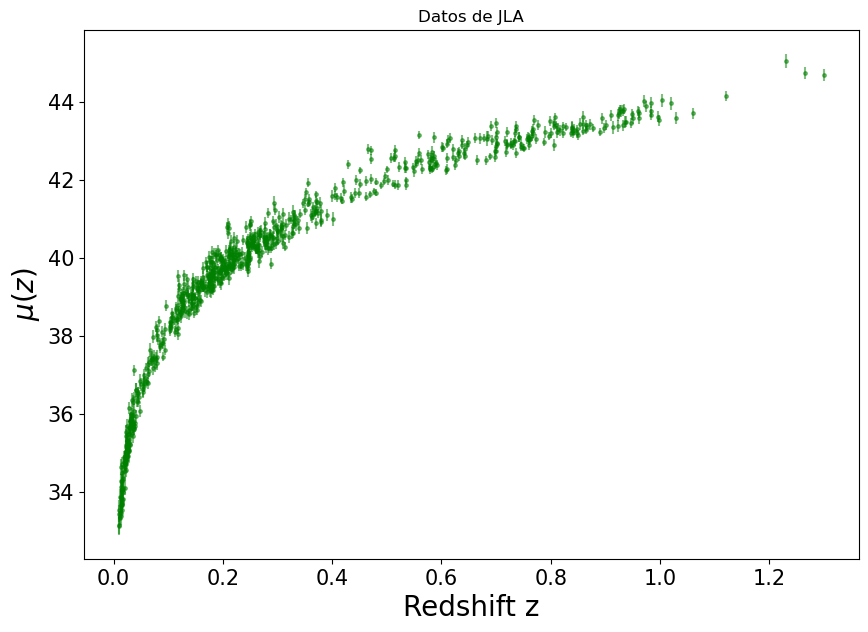

In [7]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.title("Datos de JLA")

In [8]:
N = len(df.values)
randomize = np.random.permutation(N)
data = df.values[randomize]

In [9]:
N = len(df.values)
z = data[:,0] 
y = data[:,1:3] ### coge el resto de variables a predecir 
y[:,1] = y[:,1]**2+data[:,2]
np.shape(y)

(740, 2)

In [10]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
z = scalerz.transform(z.reshape(-1,1))

# scaleryerr = MinMaxScaler(feature_range=(0,1))
# # scaleryerr = StandardScaler()
# scaleryerr.fit(y[:,1].reshape(-1, 1))
# y[:,1] = (scaleryerr.transform(y[:,1].reshape(-1, 1))).reshape(1,-1)

In [11]:
### Modificar para incluir phanteon como test
split = 0.75
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [12]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=10.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [13]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [14]:
yy = y
zz = z
split = 0.75
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((555, 1), (555, 2), (185, 1), (185, 2))

In [15]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], activation='relu')) 
    model.add(MCDropout(0.3)),
    model.add(Dense(units=num_hidden[1], activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[3], activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 1
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 150, 200,150])
model.compile(loss='mse', optimizer=optimizer) 
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=500,verbose=1,
                                    validation_data=(z_test, y_test))

/home/isidro/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
555/555 [==============================] - 2s 2ms/step - loss: 133.9761 - val_loss: 33.5068
Epoch 2/500
555/555 [==============================] - 1s 2ms/step - loss: 26.4724 - val_loss: 17.9291
Epoch 3/500
555/555 [==============================] - 1s 2ms/step - loss: 16.8978 - val_loss: 12.6002
Epoch 4/500
555/555 [==============================] - 1s 2ms/step - loss: 11.2977 - val_loss: 8.4316
Epoch 5/500
555/555 [==============================] - 1s 2ms/step - loss: 8.6885 - val_loss: 7.4572
Epoch 6/500
555/555 [==============================] - 1s 2ms/step - loss: 6.4090 - val_loss: 6.1676
Epoch 7/500
555/555 [==============================] - 1s 2ms/step - loss: 6.2287 - val_loss: 8.1157
Epoch 8/500
555/555 [==============================] - 1s 2ms/step - loss: 6.0028 - val_loss: 5.6562
Epoch 9/500
555/555 [==============================] - 1s 2ms/step - loss: 5.6149 - val_loss: 5.0520
Epoch 10/500
555/555 [==============================] - 1s 2ms/step - loss: 5.7828 

555/555 [==============================] - 1s 2ms/step - loss: 1.6783 - val_loss: 2.1028
Epoch 82/500
555/555 [==============================] - 1s 2ms/step - loss: 2.1756 - val_loss: 2.6886
Epoch 83/500
555/555 [==============================] - 1s 2ms/step - loss: 1.8439 - val_loss: 1.9895
Epoch 84/500
555/555 [==============================] - 1s 2ms/step - loss: 2.0808 - val_loss: 2.1455
Epoch 85/500
555/555 [==============================] - 1s 2ms/step - loss: 1.6955 - val_loss: 1.8080
Epoch 86/500
555/555 [==============================] - 1s 2ms/step - loss: 1.8094 - val_loss: 1.9627
Epoch 87/500
555/555 [==============================] - 1s 2ms/step - loss: 1.7286 - val_loss: 1.4811
Epoch 88/500
555/555 [==============================] - 1s 2ms/step - loss: 1.9704 - val_loss: 1.5503
Epoch 89/500
555/555 [==============================] - 1s 2ms/step - loss: 1.8449 - val_loss: 2.1439
Epoch 90/500
555/555 [==============================] - 1s 2ms/step - loss: 1.7750 - val_loss: 

Epoch 161/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5392 - val_loss: 1.7281
Epoch 162/500
555/555 [==============================] - 1s 2ms/step - loss: 1.6166 - val_loss: 1.7756
Epoch 163/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5858 - val_loss: 1.8974
Epoch 164/500
555/555 [==============================] - 1s 2ms/step - loss: 1.7848 - val_loss: 1.5445
Epoch 165/500
555/555 [==============================] - 1s 2ms/step - loss: 1.4960 - val_loss: 1.6824
Epoch 166/500
555/555 [==============================] - 1s 2ms/step - loss: 1.6435 - val_loss: 1.5100
Epoch 167/500
555/555 [==============================] - 1s 2ms/step - loss: 1.7727 - val_loss: 1.8818
Epoch 168/500
555/555 [==============================] - 1s 2ms/step - loss: 1.4937 - val_loss: 1.9332
Epoch 169/500
555/555 [==============================] - 1s 2ms/step - loss: 1.4830 - val_loss: 1.5891
Epoch 170/500
555/555 [==============================] - 1s 2ms/step - lo

555/555 [==============================] - 1s 2ms/step - loss: 1.4793 - val_loss: 1.3763
Epoch 241/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5388 - val_loss: 1.5163
Epoch 242/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5791 - val_loss: 1.7251
Epoch 243/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5760 - val_loss: 1.5802
Epoch 244/500
555/555 [==============================] - 1s 2ms/step - loss: 1.4132 - val_loss: 1.5945
Epoch 245/500
555/555 [==============================] - 1s 2ms/step - loss: 1.6378 - val_loss: 1.6568
Epoch 246/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5018 - val_loss: 1.6884
Epoch 247/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5093 - val_loss: 1.4991
Epoch 248/500
555/555 [==============================] - 1s 2ms/step - loss: 1.5580 - val_loss: 1.3725
Epoch 249/500
555/555 [==============================] - 1s 2ms/step - loss: 1.4995 - v

555/555 [==============================] - 1s 2ms/step - loss: 1.4305 - val_loss: 1.4319
Epoch 320/500
555/555 [==============================] - 1s 2ms/step - loss: 1.3412 - val_loss: 1.2147
Epoch 321/500
555/555 [==============================] - 1s 2ms/step - loss: 1.2827 - val_loss: 1.5410
Epoch 322/500
555/555 [==============================] - 1s 2ms/step - loss: 1.3807 - val_loss: 1.3542
Epoch 323/500
555/555 [==============================] - 1s 2ms/step - loss: 1.3688 - val_loss: 1.2689
Epoch 324/500
555/555 [==============================] - 1s 2ms/step - loss: 1.3491 - val_loss: 1.1948
Epoch 325/500
555/555 [==============================] - 1s 2ms/step - loss: 1.2245 - val_loss: 1.3281
Epoch 326/500
555/555 [==============================] - 1s 2ms/step - loss: 1.2807 - val_loss: 1.5201
Epoch 327/500
555/555 [==============================] - 1s 2ms/step - loss: 1.3913 - val_loss: 1.2249
Epoch 328/500
555/555 [==============================] - 1s 2ms/step - loss: 1.3380 - v

555/555 [==============================] - 1s 3ms/step - loss: 1.3268 - val_loss: 1.2444
Epoch 399/500
555/555 [==============================] - 1s 3ms/step - loss: 1.3753 - val_loss: 1.2645
Epoch 400/500
555/555 [==============================] - 1s 2ms/step - loss: 1.2979 - val_loss: 1.3056
Epoch 401/500
555/555 [==============================] - 1s 3ms/step - loss: 1.2480 - val_loss: 1.0159
Epoch 402/500
555/555 [==============================] - 1s 3ms/step - loss: 1.1765 - val_loss: 1.5151
Epoch 403/500
555/555 [==============================] - 1s 2ms/step - loss: 1.3928 - val_loss: 1.1413
Epoch 404/500
555/555 [==============================] - 2s 3ms/step - loss: 1.1666 - val_loss: 1.6053
Epoch 405/500
555/555 [==============================] - 2s 4ms/step - loss: 1.2554 - val_loss: 1.1796
Epoch 406/500
555/555 [==============================] - 2s 4ms/step - loss: 1.3346 - val_loss: 1.3064
Epoch 407/500
555/555 [==============================] - 2s 4ms/step - loss: 1.1528 - v

555/555 [==============================] - 1s 2ms/step - loss: 1.0150 - val_loss: 1.2998
Epoch 478/500
555/555 [==============================] - 1s 2ms/step - loss: 1.2014 - val_loss: 1.3294
Epoch 479/500
555/555 [==============================] - 1s 3ms/step - loss: 1.0785 - val_loss: 1.0465
Epoch 480/500
555/555 [==============================] - 1s 2ms/step - loss: 1.0792 - val_loss: 1.1324
Epoch 481/500
555/555 [==============================] - 1s 2ms/step - loss: 1.1630 - val_loss: 1.0769
Epoch 482/500
555/555 [==============================] - 1s 2ms/step - loss: 1.2095 - val_loss: 1.0874
Epoch 483/500
555/555 [==============================] - 1s 2ms/step - loss: 1.0893 - val_loss: 1.4107
Epoch 484/500
555/555 [==============================] - 1s 2ms/step - loss: 1.1033 - val_loss: 1.3091
Epoch 485/500
555/555 [==============================] - 1s 2ms/step - loss: 1.1384 - val_loss: 1.1027
Epoch 486/500
555/555 [==============================] - 1s 2ms/step - loss: 1.0623 - v

In [16]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [17]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(1.7636640472394012, 0.011202647812309775)

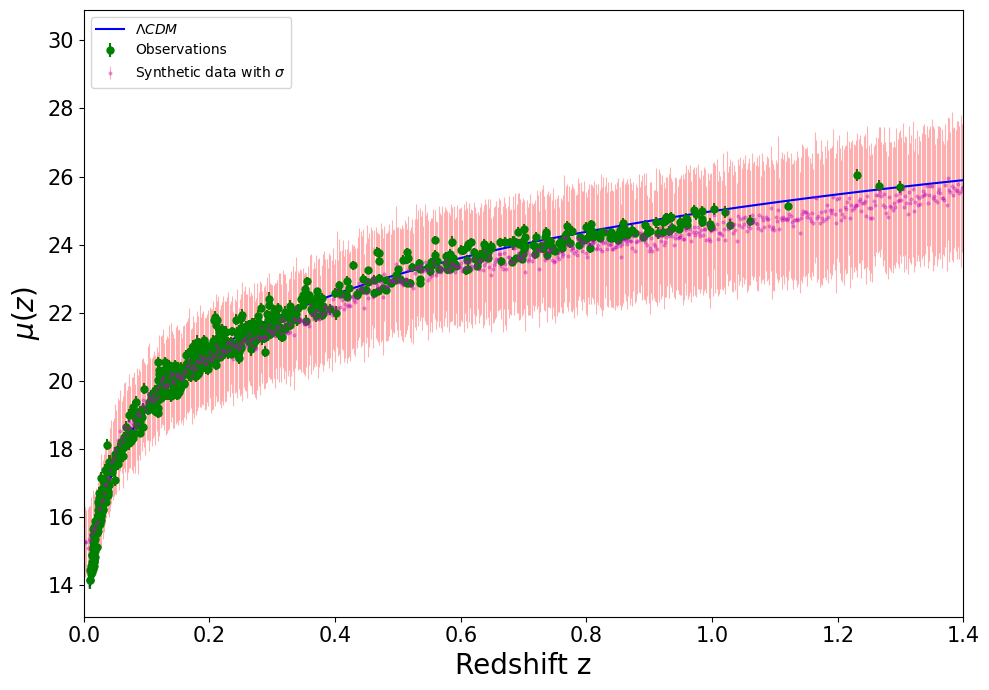

In [18]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)

# errpred = scaleryerr.inverse_transform(prediction_mc_dropout[:,1].reshape(-1,1))
errpred = prediction_mc_dropout[:,1]
ln = len(errpred)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ errpred.reshape(ln,)**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['dmb']**2+df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.4)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()


In [19]:
 prediction_mc_dropout[0,:]

array([15.30092848,  0.16443686])

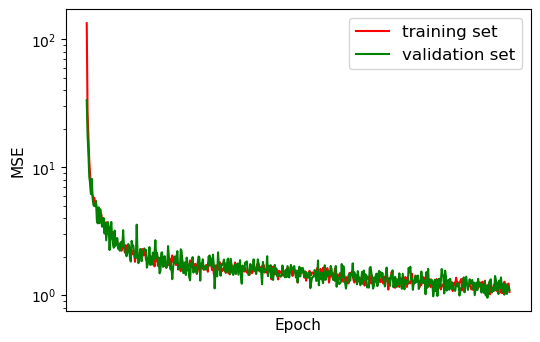

In [20]:
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
plt.yscale('log')
plt.savefig('loss_v3.png')

In [21]:
mookdp = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("data.dat",mookdp, delimiter=" ")

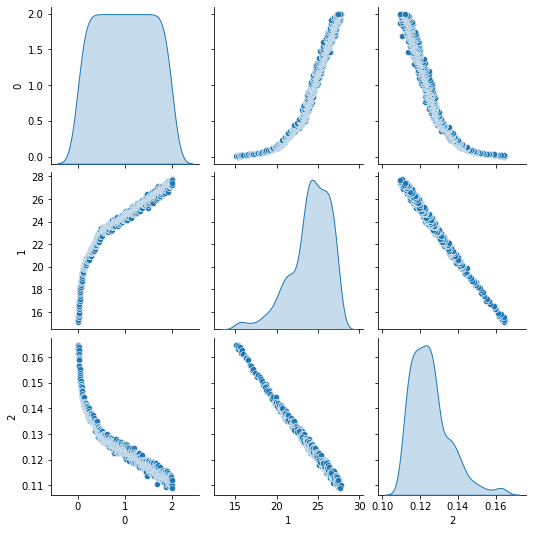

In [22]:
dfMook = pd.DataFrame(mookdp)
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")

In [23]:
model.save('FFNN_MCDO4is.h5')

PREDICCIÓN SOBRE DATOS DE TESTEO 

In [24]:
from keras.models import load_model

In [25]:
model2 = load_model('FFNN_MCDO4is.h5', custom_objects={'MCDropout': MCDropout})

In [26]:
import pandas as pd
df=pd.read_csv('../../data/not_in _jla.csv')

In [27]:
dmag =df["dmb"]

In [28]:
#df = df[["zcmb", "mb","errors"]]

In [29]:
N = len(df.values)

Text(0, 0.5, '$\\mu(z)$')

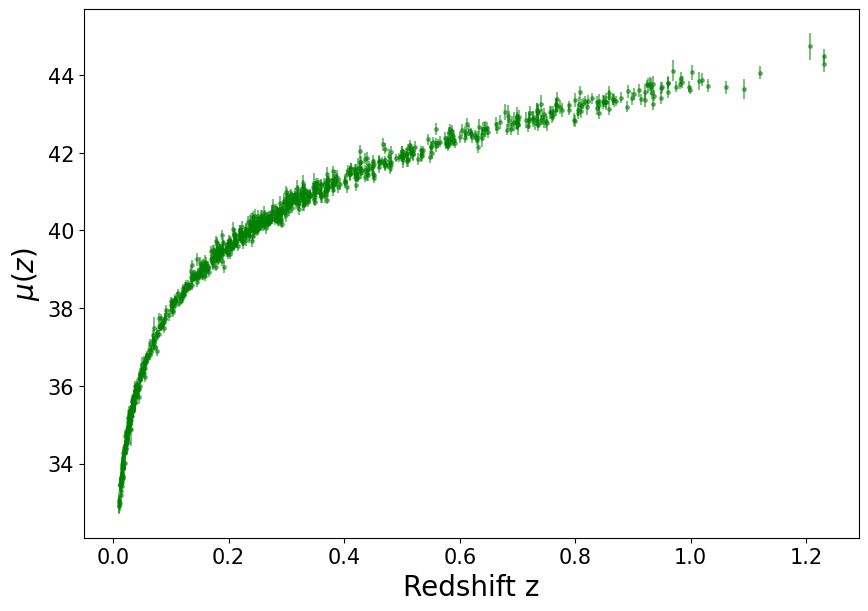

In [30]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
# plt.xlim(0, 2.3)

In [31]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [32]:
z = data[:,0]
y = data[:,1:3]
y[:,1] = data[:,1]**2+data[:,2]

In [33]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# y[:,1] = (scaleryerr.transform(y[:,1].reshape(-1, 1))).reshape(1,-1)

In [34]:
### Modificar para incluir phanteon como test
split = 0.0
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [35]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))
    
flcdm = np.array(flcdm)

In [36]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.0
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((0, 1), (0, 1), (895, 1), (895, 1))

In [37]:
# Generate test data
test_batch_size = 1000
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [38]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(1.7706731712646886, 0.011200194688691118)

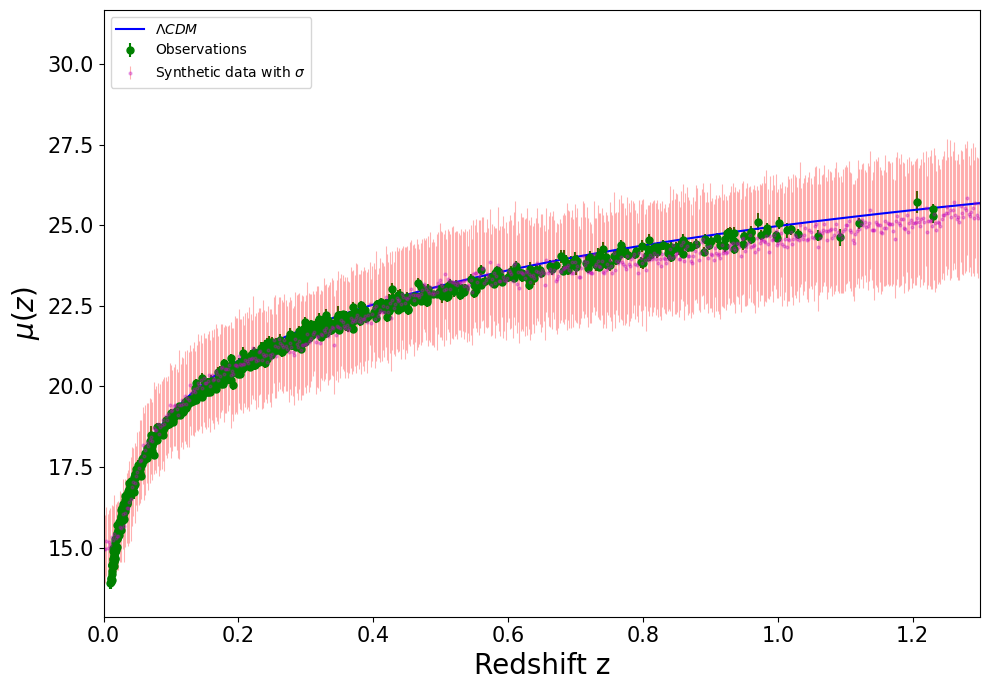

In [39]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# errpred = scaleryerr.inverse_transform(prediction_mc_dropout[:,1].reshape(-1,1))
errpred = prediction_mc_dropout[:,1]
ln = len(errpred)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ errpred.reshape(ln,)**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)
plt.xlim(0, 1.3)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig("prediction_MCDO.png")